In [1]:
import sys
import numpy as np
import pandas as pd
import scipy as sp
import scanpy as sc
import cassiopeia as cas
import seaborn as sns
import collections
import scipy.sparse as sp_sparse
import scipy.io
import tables
import csv
import itertools

from matplotlib.pyplot import rc_context
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from pylab import *
from ete3 import Tree
from typing import Tuple

import statistics as stats

In [2]:
# Load the table of cell states
cell_state_table = pd.read_csv('/Genomics/chanlab/blaw/TLS/metadata/TLS_TLSCL_cellBC_cellState.tsv', sep='\t')

clusterColorsFile = "/Genomics/chanlab/mchan/Adriano/TLS/TLS_TLSCL/20211102_clusterColorsTLSCL.p"
with open(clusterColorsFile,'rb') as fp:
    colorDict = pickle.load(fp)
    
multiSeq_BC = pd.read_csv('/Genomics/chanlab/blaw/TLS/metadata/multiseq_barcodes.txt', sep = '\t')

In [3]:
# Helpful lists. Removing Bar8 and Bar18
barcodes = ["Bar1", 'Bar2', 'Bar3', 'Bar4', 'Bar5', 'Bar6','Bar7','Bar9','Bar10','Bar11', 'Bar12', 'Bar13','Bar14',
            'Bar15', 'Bar16', 'Bar19','Bar20','Bar21', 'Bar22','Bar23','Bar24']

TLS_barcodes = ['Bar1', 'Bar2', 'Bar4', 'Bar5', 'Bar7', 'Bar10', 'Bar11', 'Bar13', 'Bar16', 'Bar19', 'Bar22']
TLSCL_barcodes = ['Bar3', 'Bar6', 'Bar9', 'Bar12', 'Bar14', 'Bar15', 'Bar20', 'Bar21', 'Bar23', 'Bar24']

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
          '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
          '#ffffff', '#000000']

### Helpful Functions

In [4]:
def addTLSCL(BC):
    test = multiSeq_BC.set_index('ID').loc[BC]['TLS ID']
    if test.startswith('TLSCL'):
        return 'TLSCL'
    elif test == 'Doublet':
        return 'Doublet'
    elif test == 'Negative':
        return 'Negative'
    else:
        return 'TLS'

In [5]:
def maxDepth(node):
    '''
    Input:
        - a node in an ete tree
    returns:
        - The max depth of any branch in that node
    '''
    if node.is_leaf():
        return 0
    children_depths = []
    
    for child in node.children:
        test = maxDepth(child)
        
        children_depths.append(test)
        
    return max(children_depths) + 1

In [8]:
def countNMP_Somite_Neural(node, cell_state_table):
    '''
    Input:
        - a node in an ete tree
        - a table of cell states for each cellBC
    return:
        - A tuple of the number of NMP, somitic, and neural cells that are leaves of the node
    '''
    leaves = [leaf.name for leaf in node.get_leaves()]

    cell_types = cell_state_table[cell_state_table['cellBC'].isin(leaves)]['cell_state'].to_list()

    # Group the Neural and Somite cell states into 1 category and remove PGCLC, Endoderm, Unknown, Epithelial
    somitic_count = 0
    NMP_count = 0
    neural_count = 0
    for state in cell_types:
        if state in ['pPSM', 'aPSM', 'Somite', 'Somite0', 'Somite1', 'Somite-1', 'SomiteSclero', 'SomiteDermo']:
            somitic_count += 1
        elif state in ['NeuralTube1', 'NeuralTube2']:
            neural_count += 1
        elif state in ['NMPs']:
            NMP_count += 1

    return (NMP_count, somitic_count, neural_count)

In [7]:
def aitchisonDist (x, y):
    '''
    Input:
        x - a list or array of composition values in sample1
        y - a list or array of composition values in sample2
        
        Assumes that all 0 values have been removed and that the composition values in the list are connected by index
    return:
        a distance between the 2 vectors
    '''
    meanX = sum(x) / len(x)
    meanY = sum(y) / len(y)
    
    distSum = 0
    
    for index, value in enumerate(x):
        tempX = np.log(x[index] / meanX)
        tempY = np.log(y[index] / meanY)
        
        distSum += (tempX - tempY) ** 2
        
    return np.sqrt(distSum)

# Create a node table across all experiments
- Nodes will be filtered to remove any node that contains an Endoderm, Endothelial, PGCLC, or Unknown cell type
- Nodes will be filtered based off size (removing nodes with less than 4 cells)
- All somitic cell types will be grouped into Somite
- All neural cell types will be grouped into Neural

In [9]:
node_columns = ['Barcode', 'Node', 'Node Size', 'Clone', 'Clone Size', 'Max Clone Depth', 'Dist to Clone', 'Percent NMP', 
                'Percent Somitic', 'Percent Neural']
node_info = pd.DataFrame(columns = node_columns)

# Store the node information of nodes to filter
bad_nodes = []
small_nodes = []

for barcode in barcodes:
    treeFile = "/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_newick_noMutationlessEdges_Labeled.nwk".format(barcode, barcode)
    t = Tree(treeFile, format = 1)
    
    # Add all nodes in the tree to the node_info dataframe
    node_names = []
    for node in t.traverse():
        if node.name != 'node0' and not node.is_leaf():
            node_names.append('{}_{}'.format(barcode, node.name))
            
    temp_node_info = pd.DataFrame(index = node_names, columns = node_columns)
    node_info = pd.concat((node_info, temp_node_info))
    
    # fill in node information, don't keep roots
    for clone in t.children:
        clone_max_depth = maxDepth(clone)

        for node in clone.traverse():
            if not node.is_leaf():
                leaves = [leaf.name for leaf in node.get_leaves()]
                cell_types = cell_state_table[cell_state_table['cellBC'].isin(leaves)]['cell_state'].to_list()
                
                # Record nodes that need to be removed
                if 'Endoderm' in cell_types or 'PCGLC' in cell_types or 'Unknown' in cell_types or 'Endothelial' in cell_types:
                    bad_nodes.append('{}_{}'.format(barcode, node.name))
                elif len(leaves) < 4:
                    small_nodes.append('{}_{}'.format(barcode, node.name))
                
                NMP_count, somitic_count, neural_count = countNMP_Somite_Neural(node, cell_state_table)
                
                total = sum(somitic_count + NMP_count + neural_count)
                if total > 0:
                    NMP_frac = NMP_count / total
                    somitic_frac = somitic_count / total
                    neural_frac = neural_count / total
                else:
                    NMP_frac = 0
                    somitic_frac = 0
                    neural_frac = 0
                
                # Record node information to the large table
                node_info.loc['{}_{}'.format(barcode, node.name)]['Barcode'] = barcode
                node_info.loc['{}_{}'.format(barcode, node.name)]['Node'] = node.name
                node_info.loc['{}_{}'.format(barcode, node.name)]['Node Size'] = len(node.get_leaves())
                node_info.loc['{}_{}'.format(barcode, node.name)]['Clone'] = clone.name
                node_info.loc['{}_{}'.format(barcode, node.name)]['Clone Size'] = len(clone.get_leaves())
                node_info.loc['{}_{}'.format(barcode, node.name)]['Max Clone Depth'] = clone_max_depth
                node_info.loc['{}_{}'.format(barcode, node.name)]['Dist to Clone'] = t.get_distance(clone, node)
                node_info.loc['{}_{}'.format(barcode, node.name)]['Percent NMP'] = NMP_frac
                node_info.loc['{}_{}'.format(barcode, node.name)]['Percent Somitic'] = somitic_frac
                node_info.loc['{}_{}'.format(barcode, node.name)]['Percent Neural'] = neural_frac
    
node_info.drop(index = bad_nodes, inplace = True)
node_info.drop(index = small_nodes, inplace = True)

In [10]:
# Calculate the normalized Depth of each node
node_info['Normalized Dist'] = node_info['Dist to Clone'] / node_info['Max Clone Depth']

# Add TLSCL metadata
node_info['TLSCL'] = node_info['Barcode'].map(addTLSCL)

In [11]:
# Classify nodes by progenitor type and % extant NMPs

node_info['Progenitor Type'] = '-'
node_info['Progenitor Pool'] = '-'

for node in node_info.index.values:
    # A node is bipotent if it produces both neural and somitic cells
    # Bipotent and transient bipotent (bipotent without NMPs) are both labeled as bipotent
    if (node_info.loc[node, 'Percent Neural'] > 0) and (node_info.loc[node, 'Percent Somitic'] > 0):
        node_info.loc[node, 'Progenitor Type'] = 'Bipotent'
    
    # A node is committed towards the somitic lineage if it produces somites but not neural cells
    elif (node_info.loc[node, 'Percent Somitic'] > 0) and (node_info.loc[node, 'Percent Neural'] == 0):
        node_info.loc[node, 'Progenitor Type'] = 'Somitic Committed'
    
    # A node is committed towards the neural lineage if it produces neural but not somitic cells
    elif (node_info.loc[node, 'Percent Somitic'] == 0) and (node_info.loc[node, 'Percent Neural'] > 0):
        node_info.loc[node, 'Progenitor Type'] = 'Neural Committed'
    
    # A node is proliferating if it does not produce somitic or neural cells (exclusively produces NMPs)
    elif (node_info.loc[node, 'Percent Somitic'] == 0) and (node_info.loc[node, 'Percent Neural'] == 0):
        node_info.loc[node, 'Progenitor Type'] = 'Proliferating'
        

    # A node is proliferating if it produces exclusively NMPs
    if node_info.loc[node, 'Percent NMP'] == 1:
        node_info.loc[node, 'Progenitor Pool'] = 'Proliferating'
    
    # A node is differentiating if it produces some NMPS
    elif node_info.loc[node, 'Percent NMP'] > 0:
        node_info.loc[node, 'Progenitor Pool'] = 'Differentiating'
    
    # A node is exhausted if it produces 0 NMPs
    elif node_info.loc[node, 'Percent NMP'] == 0:
        node_info.loc[node, 'Progenitor Pool'] = 'Exhausted'

In [12]:
# Save the node table for nodes >= 4
node_info.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_node_information_filtered.txt', sep = '\t')

In [13]:
# Open the filtered node table
node_info = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_node_information_filtered.txt', index_col = 0, sep = '\t')

In [14]:
# Open the previously saved node table that is unfilted by size (still removes endoderm and other unwanted cell types)
node_info_old = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_node_information_unfiltered.txt', index_col = 0, sep = '\t')

# QC before and after pruning

In [15]:
new_progenitor_types = pd.DataFrame(columns = barcodes, index = ['Bipotent', 'Neural Committed', 'Somitic Committed', 'Proliferating'])
old_progenitor_types = pd.DataFrame(columns = barcodes, index = ['Bipotent', 'Neural Committed', 'Somitic Committed', 'Proliferating'])

In [16]:
# Record info from the filtered node_info table
for barcode in barcodes:
    temp = node_info[node_info['Barcode'] == barcode].copy()
    
    new_progenitor_types.loc['Bipotent'][barcode] = len(temp[temp['Progenitor Type'] == 'Bipotent'])
    new_progenitor_types.loc['Neural Committed'][barcode] = len(temp[temp['Progenitor Type'] == 'Neural Committed'])
    new_progenitor_types.loc['Somitic Committed'][barcode] = len(temp[temp['Progenitor Type'] == 'Somitic Committed'])
    new_progenitor_types.loc['Proliferating'][barcode] = len(temp[temp['Progenitor Type'] == 'Proliferating'])

In [17]:
# Record info from the unfiltered node_info table
for barcode in barcodes:
    temp = node_info_old[node_info_old['Barcode'] == barcode].copy()
    
    old_progenitor_types.loc['Bipotent'][barcode] = len(temp[temp['Progenitor Type'] == 'Bipotent'])
    old_progenitor_types.loc['Neural Committed'][barcode] = len(temp[temp['Progenitor Type'] == 'Neural Committed'])
    old_progenitor_types.loc['Somitic Committed'][barcode] = len(temp[temp['Progenitor Type'] == 'Somitic Committed'])
    old_progenitor_types.loc['Proliferating'][barcode] = len(temp[temp['Progenitor Type'] == 'Proliferating'])

In [18]:
new_progenitor_frac = new_progenitor_types.div(new_progenitor_types.sum(axis = 0)).copy()
old_progenitor_frac = old_progenitor_types.div(old_progenitor_types.sum(axis = 0)).copy()

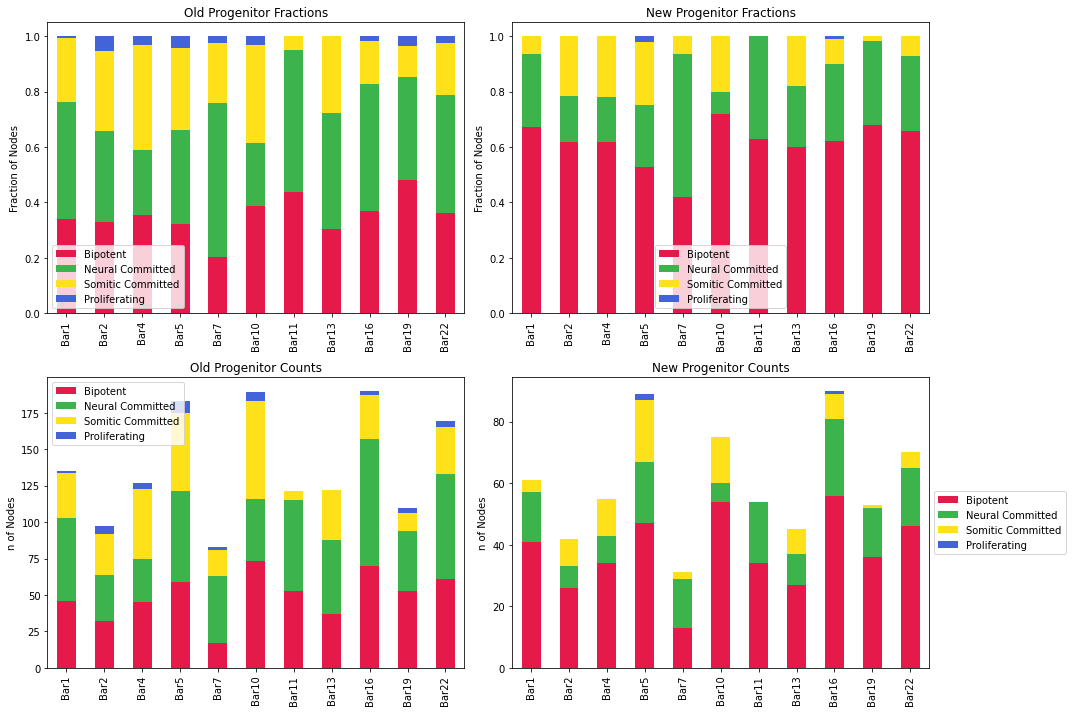

In [19]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10))

ax1 = ax[0, 0]
old_progenitor_frac[TLS_barcodes].T.plot(kind='bar', use_index = True, stacked=True, color = colors, grid = False, ax = ax1)
ax1.set_title('Old Progenitor Fractions')
ax1.set_ylabel('Fraction of Nodes')

ax2 = ax[0, 1]
new_progenitor_frac[TLS_barcodes].T.plot(kind='bar', use_index = True, stacked=True, color = colors, grid = False, ax = ax2)
ax2.set_title('New Progenitor Fractions')
ax2.set_ylabel('Fraction of Nodes')

ax3 = ax[1, 0]
old_progenitor_types[TLS_barcodes].T.plot(kind='bar', use_index = True, stacked=True, color = colors, grid = False, ax = ax3)
ax3.set_title('Old Progenitor Counts')
ax3.set_ylabel('n of Nodes')

ax4 = ax[1, 1]
new_progenitor_types[TLS_barcodes].T.plot(kind='bar', use_index = True, stacked=True, color = colors, grid = False, ax = ax4)
ax4.set_title('New Progenitor Counts')
ax4.set_ylabel('n of Nodes')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/Pruning_Progenitor_Fractions.pdf', dpi = 300)
plt.show()
plt.close()

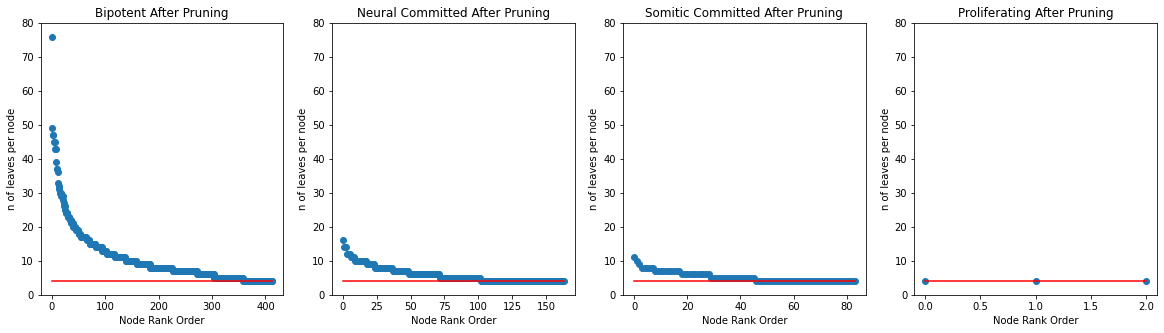

In [20]:
# TLS nodes after pruning
fig, ax = plt.subplots(1, 4, figsize = (20, 5))

count = 0
for progenitor in ['Bipotent', 'Neural Committed', 'Somitic Committed', 'Proliferating']:
    temp_ax = ax[count]
    count += 1
    
    x = np.arange(len(node_info[(node_info['TLSCL'] == 'TLS') & (node_info['Progenitor Type'] == progenitor)]))
    temp_ax.scatter(x = x, y = sorted(node_info[(node_info['TLSCL'] == 'TLS') & (node_info['Progenitor Type'] == progenitor)]['Node Size'], reverse = True))
    temp_ax.set_title(progenitor + ' After Pruning')
    temp_ax.set_xlabel('Node Rank Order')
    temp_ax.set_ylabel('n of leaves per node')
    temp_ax.set_ylim(0, 80)
    
    y = [4 for i in x]
    temp_ax.plot(x, y, 'r')

plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/Nodes_by_Size_After_Pruning.pdf', dpi = 300)
plt.show()
plt.close()

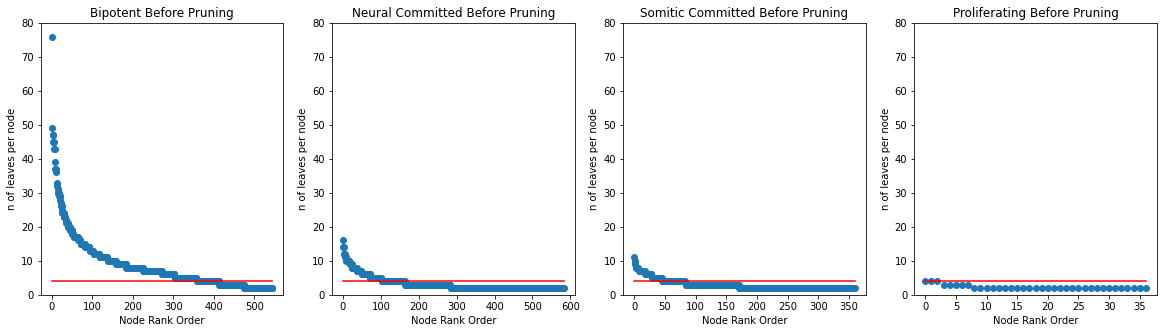

In [21]:
# TLS nodes before pruning
fig, ax = plt.subplots(1, 4, figsize = (20, 5))

count = 0
for progenitor in ['Bipotent', 'Neural Committed', 'Somitic Committed', 'Proliferating']:
    temp_ax = ax[count]
    count += 1
    
    x = np.arange(len(node_info_old[(node_info_old['TLSCL'] == 'TLS') & (node_info_old['Progenitor Type'] == progenitor)]))
    temp_ax.scatter(x = x, y = sorted(node_info_old[(node_info_old['TLSCL'] == 'TLS') & (node_info_old['Progenitor Type'] == progenitor)]['Node Size'], reverse = True))
    temp_ax.set_title(progenitor + ' Before Pruning')
    temp_ax.set_xlabel('Node Rank Order')
    temp_ax.set_ylabel('n of leaves per node')
    temp_ax.set_ylim(0, 80)
    
    y = [4 for i in x]
    temp_ax.plot(x, y, 'r')

plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/Nodes_by_Size_Before_Pruning.pdf', dpi = 300)
plt.show()
plt.close()

In [22]:
composition = pd.DataFrame(columns = barcodes, index = colorDict.keys())
composition_unpruned = pd.DataFrame(columns = barcodes, index = colorDict.keys())
for i in composition.index:
    for c in composition.columns:
        composition.loc[i, c] = 0
        composition_unpruned.loc[i, c] = 0

In [23]:
# Record the compositions in each structure after pruning
for barcode in barcodes:
    treeFile = "/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_newick_noMutationlessEdges_Labeled.nwk".format(barcode, barcode)
    t = Tree(treeFile, format = 1)
    
    cellBC = set()
    
    for node in t.traverse():
        if barcode + '_' + node.name in node_info.index.values:
            for cell in node.get_leaves():
                cellBC.add(cell.name)
                
    for cell in cellBC:
        composition.loc[cell_state_table[cell_state_table['cellBC'] == cell]['cell_state'].to_list()[0]][barcode] += 1

In [24]:
# Record the compositions in each structure before pruning
for barcode in barcodes:
    treeFile = "/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_newick_noMutationlessEdges_Labeled.nwk".format(barcode, barcode)
    t = Tree(treeFile, format = 1)
    
    cellBC = set()
    
    for node in t.traverse():
        if barcode + '_' + node.name in node_info_old.index.values:
            for cell in node.get_leaves():
                cellBC.add(cell.name)
                
    for cell in cellBC:
        composition_unpruned.loc[cell_state_table[cell_state_table['cellBC'] == cell]['cell_state'].to_list()[0]][barcode] += 1

In [25]:
composition_frac = composition.div(composition.sum(axis = 0)).copy()
composition_unpruned_frac = composition_unpruned.div(composition_unpruned.sum(axis = 0)).copy()

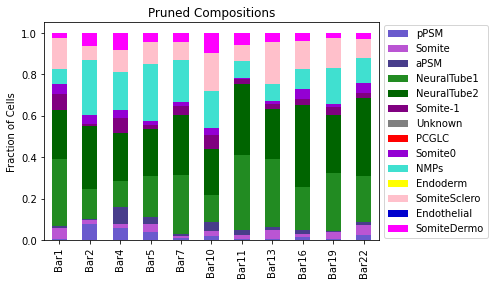

In [26]:
composition_frac[TLS_barcodes].T.plot(kind='bar', use_index = True, stacked=True, color = colorDict, grid = False)
plt.title('Pruned Compositions')
plt.ylabel('Fraction of Cells')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLS_NMP_Node_Pruned_Compositions.pdf', dpi = 300)
plt.show()
plt.close()

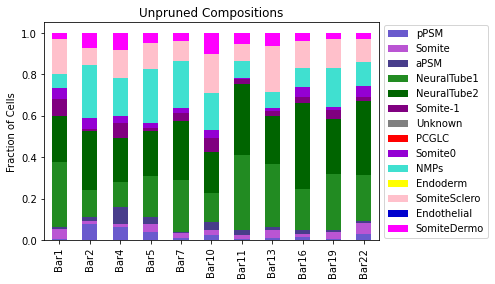

In [27]:
composition_unpruned_frac[TLS_barcodes].T.plot(kind='bar', use_index = True, stacked=True, color = colorDict, grid = False)
plt.title('Unpruned Compositions')
plt.ylabel('Fraction of Cells')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLS_NMP_Node_Compositions.pdf', dpi = 300)
plt.show()
plt.close()

# All downstream analysis was done with the filtered node table

In [28]:
TLS_node_info = node_info[node_info['TLSCL'] == 'TLS'].copy()
TLSCL_node_info = node_info[node_info['TLSCL'] == 'TLSCL'].copy()

### Plots showing the distributions of normalized distances for each progenitor type

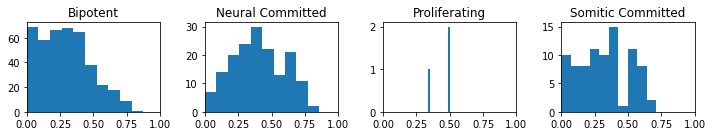

In [29]:
fig, ax = plt.subplots(1, 4, figsize = (10, 2))

count = 0
for progenitor in np.unique(TLS_node_info['Progenitor Type']):
    test_ax = ax[count]
    count += 1

    test_ax.hist(TLS_node_info[TLS_node_info['Progenitor Type'] == progenitor]['Normalized Dist'])
    test_ax.set_title(progenitor)
    test_ax.set_xlim(0, 1)
plt.tight_layout()    
plt.show()
plt.close()

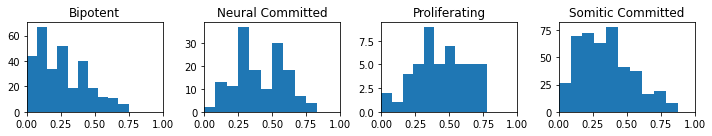

In [30]:
fig, ax = plt.subplots(1, 4, figsize = (10, 2))

count = 0
for progenitor in np.unique(TLSCL_node_info['Progenitor Type']):
    test_ax = ax[count]
    count += 1

    test_ax.hist(TLSCL_node_info[TLSCL_node_info['Progenitor Type'] == progenitor]['Normalized Dist'])
    test_ax.set_title(progenitor)
    test_ax.set_xlim(0, 1)
plt.tight_layout()    
plt.show()
plt.close()

In [31]:
node_info['Normalized Dist'] = node_info['Normalized Dist'].astype('float')
TLS_node_info['Normalized Dist'] = TLS_node_info['Normalized Dist'].astype('float')
TLSCL_node_info['Normalized Dist'] = TLSCL_node_info['Normalized Dist'].astype('float')

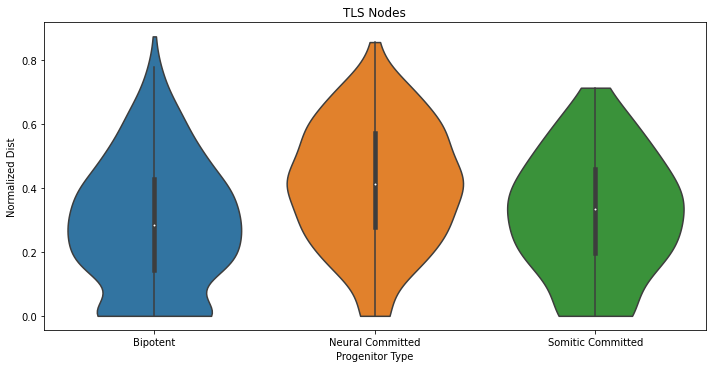

In [32]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.violinplot(ax = ax, data = node_info[node_info['TLSCL'] == 'TLS'], x = 'Progenitor Type', y = 'Normalized Dist', 
               scale = 'area', cut = 0, order = ['Bipotent', 'Neural Committed', 'Somitic Committed'])
plt.tight_layout()
plt.title('TLS Nodes')
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLS_Progenitor_Type_Normalized_Dist.pdf', dpi = 300)
plt.show()
plt.close()

### Triangle plots of % Neural vs % Somitic

In [33]:
progenitor_type = [('Bipotent', '.y'), ('Neural Committed', '.g'), ('Somitic Committed', '.r'), ('Proliferating', '.b')]

In [34]:
# Plot % neural vs % somitic for each node in TLS and TLSCL
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax1 = ax[0]
ax1.set_xlabel('Percent Neural')
ax1.set_ylabel('Percent Somitic')
ax1.set_title('TLS Nodes')
for progenitor, color in progenitor_type:
    ax1.plot(TLS_node_info[TLS_node_info['Progenitor Type'] == progenitor]['Percent Neural'],
             TLS_node_info[TLS_node_info['Progenitor Type'] == progenitor]['Percent Somitic'], 
             color, label = progenitor, alpha = 0.2)
    
ax2 = ax[1]
ax2.set_xlabel('Percent Neural')
ax2.set_ylabel('Percent Somitic')
ax2.set_title('TLSCL Nodes')
for progenitor, color in progenitor_type:
    ax2.plot(TLSCL_node_info[TLSCL_node_info['Progenitor Type'] == progenitor]['Percent Neural'],
             TLSCL_node_info[TLSCL_node_info['Progenitor Type'] == progenitor]['Percent Somitic'], 
             color, label = progenitor, alpha = 0.2)

plt.legend()
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLS_TLSCL_Triangle_Plots.pdf', dpi = 300)
#plt.show()
plt.close()

In [35]:
# plot each TLS barcode as a different plot
fig, ax = plt.subplots(3, 4, figsize = (16, 14))
count_1 = 0
count_2 = 0
for barcode in np.unique(TLS_node_info[TLS_node_info['Barcode'] != 'Bar8']['Barcode']):
    temp_ax = ax[count_1, count_2]
    count_2 += 1
    if count_2 > 3:
        count_1 += 1
        count_2 = 0
    
    for progenitor, color in progenitor_type:
        temp_ax.plot(TLS_node_info[(TLS_node_info['Barcode'] == barcode) & (TLS_node_info['Progenitor Type'] == progenitor)]['Percent Neural'],
                     TLS_node_info[(TLS_node_info['Barcode'] == barcode) & (TLS_node_info['Progenitor Type'] == progenitor)]['Percent Somitic'], 
                     color, label = progenitor, alpha = 0.5)
    
    temp_ax.set_title(barcode)
    temp_ax.set_xlim(-0.05, 1.05)
    temp_ax.set_ylim(-0.05, 1.05)
    temp_ax.set_xlabel('Percent Neural')
    temp_ax.set_ylabel('Percent Somitic')
plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLS_Triangle_Plots.pdf', dpi = 300)
#plt.show()
plt.close()

In [36]:
# plot each TLSCL barcode as a different plot
fig, ax = plt.subplots(3, 4, figsize = (16, 14))
count_1 = 0
count_2 = 0
for barcode in np.unique(TLSCL_node_info[TLSCL_node_info['Barcode'] != 'Bar18']['Barcode']):
    temp_ax = ax[count_1, count_2]
    count_2 += 1
    if count_2 > 3:
        count_1 += 1
        count_2 = 0
    
    for progenitor, color in progenitor_type:
        temp_ax.plot(TLSCL_node_info[(TLSCL_node_info['Barcode'] == barcode) & (TLSCL_node_info['Progenitor Type'] == progenitor)]['Percent Neural'],
                     TLSCL_node_info[(TLSCL_node_info['Barcode'] == barcode) & (TLSCL_node_info['Progenitor Type'] == progenitor)]['Percent Somitic'], 
                     color, label = progenitor, alpha = 0.5)
    
    temp_ax.set_title(barcode)
    temp_ax.set_xlim(-0.05, 1.05)
    temp_ax.set_ylim(-0.05, 1.05)
    temp_ax.set_xlabel('Percent Neural')
    temp_ax.set_ylabel('Percent Somitic')
plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLSCL_Triangle_Plots.pdf', dpi = 300)
#plt.show()
plt.close()

# Histograms of node compositions

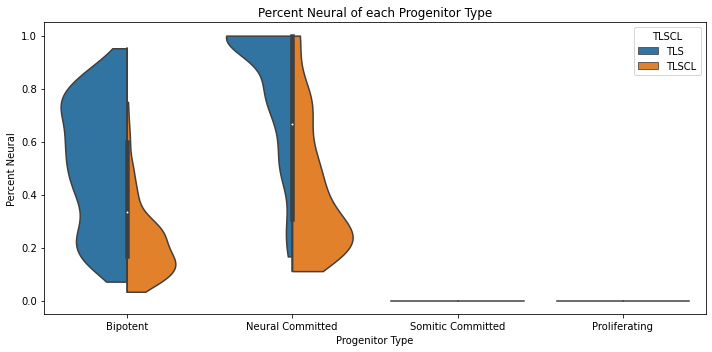

In [37]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.violinplot(ax = ax, data = node_info, x = 'Progenitor Type', y = 'Percent Neural', scale = 'count', cut = 0,
               split = True, hue = 'TLSCL',
              order = ['Bipotent', 'Neural Committed', 'Somitic Committed', 'Proliferating'])
plt.title('Percent Neural of each Progenitor Type')
plt.tight_layout()
plt.show()
plt.close()

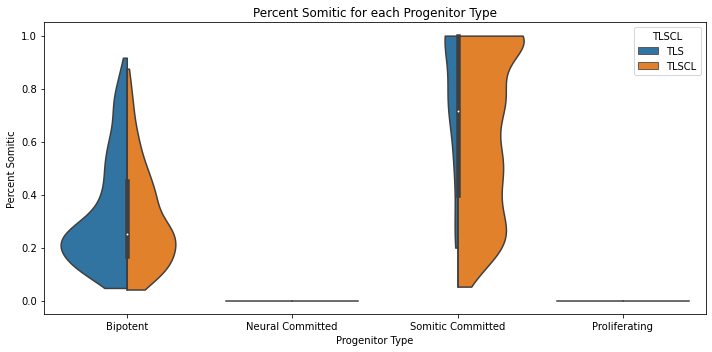

In [38]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.violinplot(ax = ax, data = node_info, x = 'Progenitor Type', y = 'Percent Somitic', scale = 'count', cut = 0,
               split = True, hue = 'TLSCL',
              order = ['Bipotent', 'Neural Committed', 'Somitic Committed', 'Proliferating'])
plt.title('Percent Somitic for each Progenitor Type')
plt.tight_layout()
plt.show()
plt.close()

In [39]:
fig, ax = plt.subplots(2, 2, figsize = (8, 8))

ax1 = ax[0, 0]
heatmap, xedges, yedges = np.histogram2d(TLS_node_info[TLS_node_info['Progenitor Type'] == 'Bipotent']['Percent Neural'], 
                                         TLS_node_info[TLS_node_info['Progenitor Type'] == 'Bipotent']['Percent Somitic'], 
                                         bins = 15)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax1.imshow(heatmap.T, extent=extent, origin='lower', cmap = 'viridis', aspect = 'auto')
ax1.set_title('TLS - Bipotent Nodes')
ax1.set_xlabel('Percent Neural')
ax1.set_ylabel('Percent Somitic')

ax2 = ax[0, 1]
heatmap, xedges, yedges = np.histogram2d(TLSCL_node_info[TLSCL_node_info['Progenitor Type'] == 'Bipotent']['Percent Neural'], 
                                         TLSCL_node_info[TLSCL_node_info['Progenitor Type'] == 'Bipotent']['Percent Somitic'], 
                                         bins = 15)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax2.imshow(heatmap.T, extent=extent, origin='lower', cmap = 'viridis', aspect = 'auto')
ax2.set_title('TLS - Bipotent Nodes')
ax2.set_xlabel('Percent Neural')
ax2.set_ylabel('Percent Somitic')

ax3 = ax[1, 0]
heatmap, xedges, yedges = np.histogram2d(TLS_node_info['Percent Neural'], 
                                         TLS_node_info['Percent Somitic'], 
                                         bins = 15)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax3.imshow(heatmap.T, extent=extent, origin='lower', cmap = 'viridis', aspect = 'auto')
ax3.set_title('TLS - Bipotent Nodes')
ax3.set_xlabel('Percent Neural')
ax3.set_ylabel('Percent Somitic')

ax4 = ax[1, 1]
heatmap, xedges, yedges = np.histogram2d(TLSCL_node_info['Percent Neural'], 
                                         TLSCL_node_info['Percent Somitic'], 
                                         bins = 15)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax4.imshow(heatmap.T, extent=extent, origin='lower', cmap = 'viridis', aspect = 'auto')
ax4.set_title('TLS - Bipotent Nodes')
ax4.set_xlabel('Percent Neural')
ax4.set_ylabel('Percent Somitic')

plt.grid(False)
plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLS_TLSCL_Triangle_Heatmaps.pdf', dpi = 300)
#plt.show()
plt.close()

### Create a table of the frequencies of each node type per structure
- Make 2 tables, one with the progenitor type classifications, and one with the progenitor pool classifications
- The categories of table 1 is Bipotent, Neural Committed, Somitic Committed, Transient NMP, Proliferating
- The categories of table 2 is Proliferating, Differentiating, and Exhausted

In [41]:
node_type_counts = pd.DataFrame(index = ['Bipotent', 'Neural Committed', 'Somitic Committed', 'Proliferating'], columns = np.unique(node_info['Barcode']))
node_pool_counts = pd.DataFrame(index = ['Proliferating', 'Differentiating', 'Exhausted'], columns = np.unique(node_info['Barcode']))

In [42]:
# Count the occurance of each progenitor type in each structure
for barcode in node_type_counts.columns.values:
    for progenitor in node_type_counts.index.values:
        node_type_counts.loc[progenitor, barcode] = len(node_info[(node_info['Barcode'] == barcode) & (node_info['Progenitor Type'] == progenitor)])
        
# Count the occurance of each differentiation type in each structure
for barcode in node_pool_counts.columns.values:
    for progenitor in node_pool_counts.index.values:
        node_pool_counts.loc[progenitor, barcode] = len(node_info[(node_info['Barcode'] == barcode) & (node_info['Progenitor Pool'] == progenitor)])

In [43]:
node_type_frac = node_type_counts.div(node_type_counts.sum(axis = 0)).copy()
node_pool_frac = node_pool_counts.div(node_pool_counts.sum(axis = 0)).copy()

In [44]:
# Save the counts tables
node_type_counts.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_node_type_counts.txt', sep = '\t')
node_pool_counts.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_node_pool_counts.txt', sep = '\t')

In [45]:
# Save the fractions tables
node_type_frac.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_node_type_frac.txt', sep = '\t')
node_pool_frac.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_node_pool_frac.txt', sep = '\t')

In [18]:
# Reopen the counts and fractions tables
node_type_counts = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_node_type_counts.txt', index_col = 0, sep = '\t')
node_pool_counts = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_node_pool_counts.txt', index_col = 0, sep = '\t')

node_type_frac = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_node_type_frac.txt', index_col = 0, sep = '\t')
node_pool_frac = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_node_pool_frac.txt', index_col = 0, sep = '\t')

### Create a table of all the paths taken by nodes
- each row will the conversion from a node to its child in a tree with the following information recorded (Barcode, parent node, child node, clone, clonesize, parent dist to clone, max clone depth, parent type, parent pool, child type, child pool, % NMP parent, % neural parent, % somitic parent, % NMP child, % neural child, % somitic child

In [94]:
columns_of_interest = ['Barcode', 'Parent Node', 'Child Node', 'Clone', 'Clone Size', 'Max Clone Depth', 
                       'Parent Dist to Clone', 'Parent % NMP', 'Parent % Somitic', 'Parent % Neural',
                       'Child % NMP', 'Child % Somitic', 'Child % Neural', 'Parent Type', 'Parent Pool',
                       'Child Type', 'Child Pool', 'Type Path', 'Pool Path']
path_info = pd.DataFrame(columns = columns_of_interest)

count = 0
for barcode in barcodes:
    treeFile = "/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_newick_noMutationlessEdges_Labeled.nwk".format(barcode, barcode)
    t = Tree(treeFile, format = 1)
    
    # identify all the node paths in the tree
    NMP_nodes = node_info[node_info['Barcode'] == barcode]['Node'].tolist()
    node_names = []
    for node in t.traverse():
        if node.name in NMP_nodes:
            for child in node.children:
                if child.name in NMP_nodes:
                    node_names.append('{}_{}_{}'.format(barcode, node.name, child.name))
            
    # Add these nodes to the table
    temp_path_info = pd.DataFrame(index = node_names, columns = columns_of_interest)
    path_info = pd.concat((path_info, temp_path_info))

    # fill in node information
    for clone in t.children:
        clone_max_depth = maxDepth(clone)

        for node in clone.traverse():
            if node.name in NMP_nodes:
                for child in node.children:
                    if child.name in NMP_nodes:
                        NMP_count_p, somitic_count_p, neural_count_p = countNMP_Somite_Neural(node, cell_state_table)
                        NMP_count_c, somitic_count_c, neural_count_c = countNMP_Somite_Neural(child, cell_state_table)

                        total_p = sum(somitic_count_p + NMP_count_p + neural_count_p)
                        total_c = sum(somitic_count_c + NMP_count_c + neural_count_c)
                        
                        index = '{}_{}_{}'.format(barcode, node.name, child.name)

                        # Record node information to the large table
                        path_info.loc[index]['Barcode'] = barcode
                        path_info.loc[index]['Parent Node'] = node.name
                        path_info.loc[index]['Child Node'] = child.name
                        path_info.loc[index]['Clone'] = clone.name
                        path_info.loc[index]['Clone Size'] = len(clone.get_leaves())
                        path_info.loc[index]['Max Clone Depth'] = clone_max_depth
                        path_info.loc[index]['Parent Dist to Clone'] = t.get_distance(clone, node)
                        if total_p == 0:
                            path_info.loc[index]['Parent % NMP'] = 0
                            path_info.loc[index]['Parent % Somitic'] = 0
                            path_info.loc[index]['Parent % Neural'] = 0
                        else:
                            path_info.loc[index]['Parent % NMP'] = NMP_count_p / total_p
                            path_info.loc[index]['Parent % Somitic'] = somitic_count_p / total_p
                            path_info.loc[index]['Parent % Neural'] = neural_count_p / total_p
                        if total_c == 0:
                            path_info.loc[index]['Child % NMP'] = 0
                            path_info.loc[index]['Child % Somitic'] = 0
                            path_info.loc[index]['Child % Neural'] = 0
                        else:
                            path_info.loc[index]['Child % NMP'] = NMP_count_c / total_c
                            path_info.loc[index]['Child % Somitic'] = somitic_count_c / total_c
                            path_info.loc[index]['Child % Neural'] = neural_count_c / total_c
                            
                        # Classify parent node progenitor type
                        path_info.loc[index, 'Parent Type'] = node_info.loc['{}_{}'.format(barcode, node.name)]['Progenitor Type']
                            
                        # Classify parent node progenitor type
                        path_info.loc[index, 'Child Type'] = node_info.loc['{}_{}'.format(barcode, child.name)]['Progenitor Type']
                        
                        # Classify parent node pool type
                        path_info.loc[index, 'Parent Pool'] = node_info.loc['{}_{}'.format(barcode, node.name)]['Progenitor Pool']
                        
                        # Classify parent node pool type
                        path_info.loc[index, 'Child Pool'] = node_info.loc['{}_{}'.format(barcode, child.name)]['Progenitor Pool']

                        path_info.loc[index, 'Type Path'] = path_info.loc[index, 'Parent Type'] + '_' + path_info.loc[index, 'Child Type']
                        path_info.loc[index, 'Pool Path'] = path_info.loc[index, 'Parent Pool'] + '_' + path_info.loc[index, 'Child Pool']

# Calculate the normalized Depth
path_info['Parent Normalized Dist'] = path_info['Parent Dist to Clone'] / path_info['Max Clone Depth']

# Add TLSCL metadata
path_info['TLSCL'] = path_info['Barcode'].map(addTLSCL)

In [97]:
# Path info of all nodes in the filtered node_info table
path_info.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_path_information_filtered.txt', sep = '\t')

In [98]:
# Open the filtered path info
path_info = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_path_information_filtered.txt', index_col = 0, sep = '\t')

In [99]:
path_info['Parent Normalized Dist'] = path_info['Parent Normalized Dist'].astype('float')

In [100]:
path_info['Parent % Somitic'] = path_info['Parent % Somitic'].astype('float')
path_info['Child % Somitic'] = path_info['Child % Somitic'].astype('float')
path_info['Parent % NMP'] = path_info['Parent % NMP'].astype('float')
path_info['Child % NMP'] = path_info['Child % NMP'].astype('float')

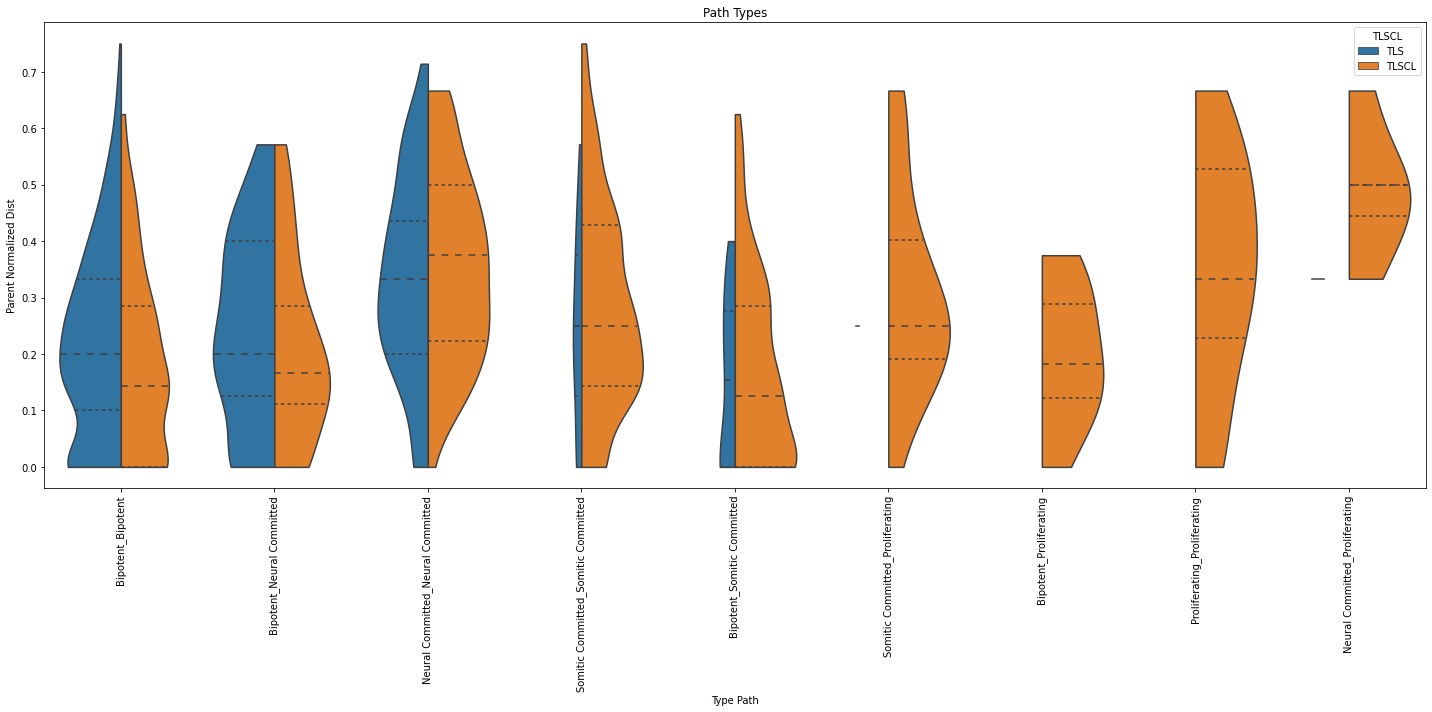

In [101]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.violinplot(ax = ax, data = path_info, split = True, hue = 'TLSCL', x = 'Type Path', y = 'Parent Normalized Dist', 
               inner = 'quartile', scale = 'count', cut = 0)
plt.tight_layout()
plt.title('Path Types')
plt.xticks(rotation = '90')
plt.tight_layout()

plt.show()
plt.close()

### Create a table of the counts of each path transition vs the structure

In [102]:
path_type_counts = pd.DataFrame(index = np.unique(path_info['Type Path']), columns = np.unique(path_info['Barcode']))
path_pool_counts = pd.DataFrame(index = np.unique(path_info['Pool Path']), columns = np.unique(path_info['Barcode']))

In [103]:
for barcode in path_type_counts.columns.values:
    for path in path_type_counts.index.values:
        path_type_counts.loc[path, barcode] = len(path_info[(path_info['Barcode'] == barcode) & (path_info['Type Path'] == path)])
        
for barcode in path_pool_counts.columns.values:
    for path in path_pool_counts.index.values:
        path_pool_counts.loc[path, barcode] = len(path_info[(path_info['Barcode'] == barcode) & (path_info['Pool Path'] == path)])

In [105]:
path_type_frac = path_type_counts.div(path_type_counts.sum(axis = 0)).copy()
path_pool_frac = path_pool_counts.div(path_pool_counts.sum(axis = 0)).copy()

In [108]:
path_type_counts.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_path_type_counts.txt', sep = '\t')
path_pool_counts.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_path_pool_counts.txt', sep = '\t')

In [109]:
path_type_frac.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_path_type_frac.txt', sep = '\t')
path_pool_frac.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_path_pool_frac.txt', sep = '\t')

In [49]:
path_type_counts = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_path_type_counts.txt', index_col = 0, sep = '\t')
path_pool_counts = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_path_pool_counts.txt', index_col = 0, sep = '\t')
path_type_frac = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_path_type_frac.txt', index_col = 0, sep = '\t')
path_pool_frac = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/AM-DNA-258_path_pool_frac.txt', index_col = 0, sep = '\t')

### Calculate distances between nodes, paths, and composition for each structure
For each pairwise structure comparision, calculate the aitchison's distance between the following:
- composition frequencies
- Node Type frequencies
- Node pool frequencies
- path type frequencies
- path pool frequencies

Save as a table with indexes of each structure and columns of each compairison_structure

In [46]:
# Make a DataFrame to hold all the structure comparisons
comparisons = []
for structure in barcodes:
    for comparison in ['Composition', 'Node_Type', 'Node_Pool', 'Path_Type', 'Path_Pool']:
        comparisons.append(structure + '_' + comparison)

structure_comparisons = pd.DataFrame(index = barcodes, columns = comparisons)

In [47]:
# Read in the cell state compositions of each structure
structure_composition = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/scRNA/structure_compositions.txt',index_col = 0, sep = '\t')

# Create a new table of the compositions with the somite and neural subclusters merged together
composition = pd.DataFrame(columns = barcodes, index = ['Somite', 'Neural', 'NMP', 'Other'])
type_merging = {'Somite': ['pPSM', 'Somite', 'aPSM', 'Somite-1', 'Somite0', 'SomiteSclero', 'SomiteDermo'],
               'Neural': ['NeuralTube1', 'NeuralTube2'],
               'NMP': ['NMPs'],
               'Other': ['Endoderm', 'PCGLC', 'Unknown', 'Endothelial']}

for barcode in barcodes:
    for cell_type in ['Somite', 'Neural', 'NMP', 'Other']:
        composition.loc[cell_type, barcode] = structure_composition.loc[barcode, type_merging[cell_type]].sum()

In [50]:
# Populate the comparisons table
# Add a 0.01 pseudocount value to each value because Aithison's Distance cannot handle values of 0
for barcode_1 in barcodes:
    for barcode_2 in barcodes:
        structure_comparisons.loc[barcode_1, barcode_2 + '_Composition'] = aitchisonDist(composition[barcode_1].values + 0.01, composition[barcode_2].values + 0.01)
    
        structure_comparisons.loc[barcode_1, barcode_2 + '_Node_Type'] = aitchisonDist(node_type_counts[barcode_1].values + 0.01, node_type_counts[barcode_2].values + 0.01)
        
        structure_comparisons.loc[barcode_1, barcode_2 + '_Node_Pool'] = aitchisonDist(node_pool_counts[barcode_1].values + 0.01, node_pool_counts[barcode_2].values + 0.01)
        
        structure_comparisons.loc[barcode_1, barcode_2 + '_Path_Type'] = aitchisonDist(path_type_counts[barcode_1].values + 0.01, path_type_counts[barcode_2].values + 0.01)
        
        structure_comparisons.loc[barcode_1, barcode_2 + '_Path_Pool'] = aitchisonDist(path_pool_counts[barcode_1].values + 0.01, path_pool_counts[barcode_2].values + 0.01)

In [ ]:
# Save the comparisons table
structure_comparisons.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/structure_comparisons.txt', sep = '\t')

In [53]:
# Read in the table
structure_comparisons = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/structure_comparisons.txt', index_col = 0, sep = '\t')

In [56]:
# Make lists of the TLS distances for plotting
TLS_composition_Dists = []
TLS_node_type_Dists = []
TLS_node_pool_Dists = []
TLS_path_type_Dists = []
TLS_path_pool_Dists = []

for barcode_1, barcode_2 in list(itertools.combinations(TLS_barcodes, 2)):
    TLS_composition_Dists.append(structure_comparisons.loc[barcode_1, barcode_2 + '_Composition'])
    TLS_node_type_Dists.append(structure_comparisons.loc[barcode_1, barcode_2 + '_Node_Type'])
    TLS_node_pool_Dists.append(structure_comparisons.loc[barcode_1, barcode_2 + '_Node_Pool'])
    TLS_path_type_Dists.append(structure_comparisons.loc[barcode_1, barcode_2 + '_Path_Type'])
    TLS_path_pool_Dists.append(structure_comparisons.loc[barcode_1, barcode_2 + '_Path_Pool'])

In [57]:
# Make lists of the TLSCL distances for plotting
TLSCL_composition_Dists = []
TLSCL_node_type_Dists = []
TLSCL_node_pool_Dists = []
TLSCL_path_type_Dists = []
TLSCL_path_pool_Dists = []

for barcode_1, barcode_2 in list(itertools.combinations(TLSCL_barcodes, 2)):
    TLSCL_composition_Dists.append(structure_comparisons.loc[barcode_1, barcode_2 + '_Composition'])
    TLSCL_node_type_Dists.append(structure_comparisons.loc[barcode_1, barcode_2 + '_Node_Type'])
    TLSCL_node_pool_Dists.append(structure_comparisons.loc[barcode_1, barcode_2 + '_Node_Pool'])
    TLSCL_path_type_Dists.append(structure_comparisons.loc[barcode_1, barcode_2 + '_Path_Type'])
    TLSCL_path_pool_Dists.append(structure_comparisons.loc[barcode_1, barcode_2 + '_Path_Pool'])

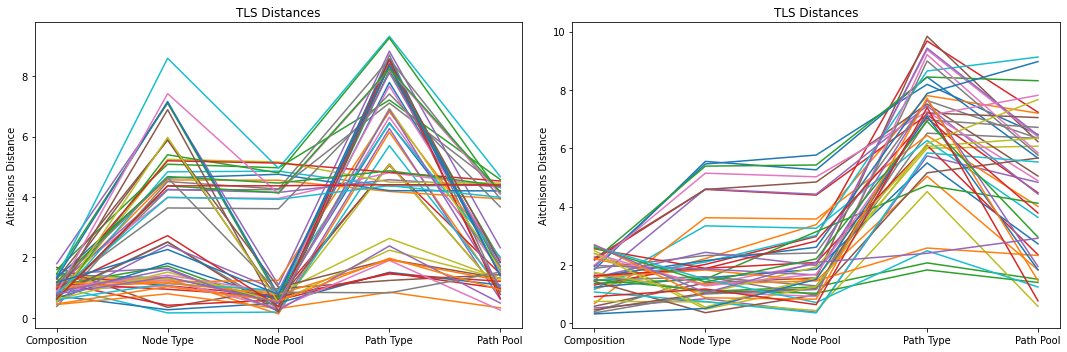

In [58]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax1 = ax[0]
ax1.set_title('TLS Distances')
ax1.set_ylabel('Aitchisons Distance')
for i,value in enumerate(TLS_composition_Dists):
    temp = [TLS_composition_Dists[i], TLS_node_type_Dists[i], TLS_node_pool_Dists[i], TLS_path_type_Dists[i], TLS_path_pool_Dists[i]]
    ax1.plot(['Composition', 'Node Type', 'Node Pool', 'Path Type', 'Path Pool'], temp)  
    
ax2 = ax[1]
ax2.set_title('TLS Distances')
ax2.set_ylabel('Aitchisons Distance')
for i,value in enumerate(TLSCL_composition_Dists):
    temp = [TLSCL_composition_Dists[i], TLSCL_node_type_Dists[i], TLSCL_node_pool_Dists[i], TLSCL_path_type_Dists[i], TLSCL_path_pool_Dists[i]]
    ax2.plot(['Composition', 'Node Type', 'Node Pool', 'Path Type', 'Path Pool'], temp)  

#plt.ylim(0, 15)
plt.tight_layout()
plt.show()
plt.close()

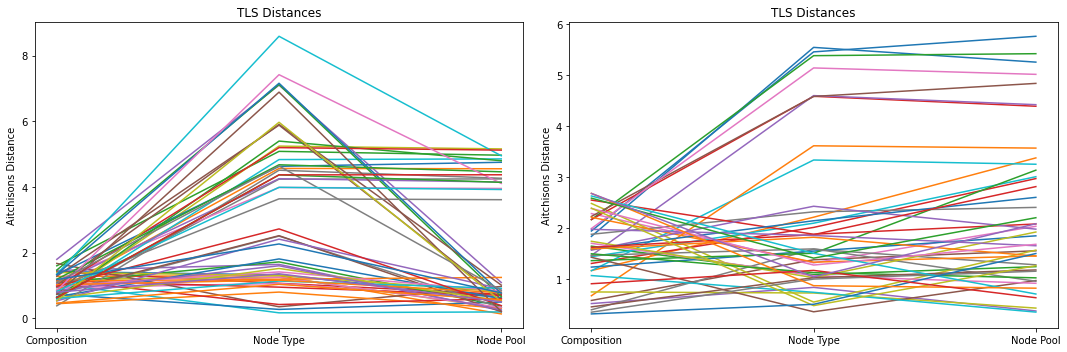

In [59]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax1 = ax[0]
ax1.set_title('TLS Distances')
ax1.set_ylabel('Aitchisons Distance')
for i,value in enumerate(TLS_composition_Dists):
    temp = [TLS_composition_Dists[i], TLS_node_type_Dists[i], TLS_node_pool_Dists[i]]
    ax1.plot(['Composition', 'Node Type', 'Node Pool'], temp)  
    
ax2 = ax[1]
ax2.set_title('TLS Distances')
ax2.set_ylabel('Aitchisons Distance')
for i,value in enumerate(TLSCL_composition_Dists):
    temp = [TLSCL_composition_Dists[i], TLSCL_node_type_Dists[i], TLSCL_node_pool_Dists[i]]
    ax2.plot(['Composition', 'Node Type', 'Node Pool'], temp)  

#plt.ylim(0, 15)
plt.tight_layout()
plt.show()
plt.close()

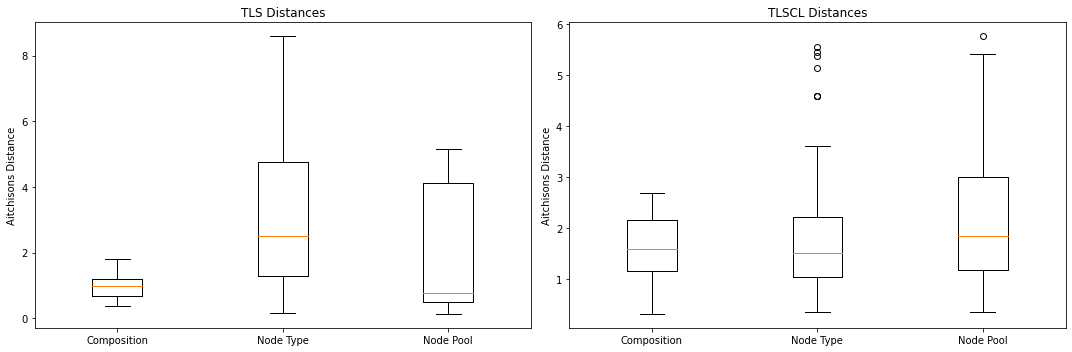

In [60]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax1 = ax[0]
ax1.set_title('TLS Distances')
ax1.set_ylabel('Aitchisons Distance')
ax1.boxplot([TLS_composition_Dists, TLS_node_type_Dists, TLS_node_pool_Dists],
           labels = ['Composition', 'Node Type', 'Node Pool'])
    
ax2 = ax[1]
ax2.set_title('TLSCL Distances')
ax2.set_ylabel('Aitchisons Distance')
ax2.boxplot([TLSCL_composition_Dists, TLSCL_node_type_Dists, TLSCL_node_pool_Dists],
           labels = ['Composition', 'Node Type', 'Node Pool'])

#plt.ylim(0, 15)
plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLS_TLSCL_Composition_Distances.pdf', dpi = 300)
plt.show()
plt.close()

### Plots of the Distribution of node types per structure
- These will be made with both the progenitor type distributions, and the differentiating NMP classifications

In [61]:
structure_pool_fracs = {}
structure_progenitor_fracs = {}

for barcode in np.unique(node_info['Barcode']):
    total = len(node_info[node_info['Barcode'] == barcode])
    prolif = len(node_info[(node_info['Barcode'] == barcode) & (node_info['Progenitor Pool'].isin(['Proliferating']))])
    differentiating = len(node_info[(node_info['Barcode'] == barcode) & (node_info['Progenitor Pool'].isin(['Differentiating']))])
    exhausted = len(node_info[(node_info['Barcode'] == barcode) & (node_info['Progenitor Pool'].isin(['Exhausted']))])

    structure_pool_fracs[barcode] = [prolif / (total-1), differentiating / (total-1), exhausted / (total-1)]
    
    bipotent = len(node_info[(node_info['Barcode'] == barcode) & (node_info['Progenitor Type'].isin(['Bipotent', 'Transient NMP']))])
    prolif = len(node_info[(node_info['Barcode'] == barcode) & (node_info['Progenitor Type'].isin(['Proliferating']))])
    neural = len(node_info[(node_info['Barcode'] == barcode) & (node_info['Progenitor Type'].isin(['Neural Committed']))])
    somitic = len(node_info[(node_info['Barcode'] == barcode) & (node_info['Progenitor Type'].isin(['Somitic Committed']))])

    structure_progenitor_fracs[barcode] = [prolif / (total-1), bipotent / (total-1), neural / (total - 1), somitic / (total-1)]

In [62]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
          '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080',
          '#ffffff', '#000000']

In [63]:
fig, ax = plt.subplots(2, 1, figsize = (10, 10))

prolif = []
differentiating = []
exhausted = []
barcodes = []
for barcode in np.unique(node_info[node_info['TLSCL'] == 'TLS']['Barcode']):
    prolif.append(structure_pool_fracs[barcode][0])
    differentiating.append(structure_pool_fracs[barcode][1])
    exhausted.append(structure_pool_fracs[barcode][2])
    barcodes.append(barcode)
    
test = pd.DataFrame({'Proliferating': prolif,
                   'Differentiating':differentiating,
                   'Exhausted': exhausted,
                    'Barcode': barcodes})

ax1 = ax[0]
count = 0
for barcode in barcodes:
    ax1.plot(['Proliferating', 'Differentiating', 'Exhausted'], structure_pool_fracs[barcode], color = colors[count])
    count += 1
ax1.set_title('TLS NMP Differentiation')
ax1.set_ylabel('Fraction of Nodes per Structure')
ax1.set_ylim(0, 1)
    
ax2 = ax[1]
sns.boxplot(ax = ax2, data = test)
count = 0
for barcode in barcodes:
    sns.stripplot(data = test[test['Barcode'] == barcode], color = colors[count])
    count += 1
ax2.set_ylabel('Fraction of Nodes Per Structure')
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLS_NMP_Differentiation.pdf', dpi = 300)
#plt.show()
plt.close()

In [68]:
fig, ax = plt.subplots(2, 1, figsize = (10, 10))

bipotent = []
prolif = []
neural = []
somitic = []
barcodes = []
for barcode in np.unique(node_info[node_info['TLSCL'] == 'TLS']['Barcode']):
    bipotent.append(structure_progenitor_fracs[barcode][1])
    prolif.append(structure_progenitor_fracs[barcode][0])
    neural.append(structure_progenitor_fracs[barcode][2])
    somitic.append(structure_progenitor_fracs[barcode][3])
    barcodes.append(barcode)
    
test = pd.DataFrame({'Proliferating': prolif,
                     'Bipotent': bipotent,
                     'Neural Committed': neural,
                     'Somitic Committed': somitic,
                    'Barcode': barcodes})

ax1 = ax[0]
count = 0
for barcode in barcodes:
    ax1.plot(['Proliferating', 'Bipotent', 'Neural Committed', 'Somitic Committed'], structure_progenitor_fracs[barcode], color = colors[count])
    count += 1
ax1.set_title('TLS Progenitor Nodes')
ax1.set_ylabel('Fraction of Nodes per Structure')
ax1.set_ylim(0, 1)
    
ax2 = ax[1]
sns.boxplot(ax = ax2, data = test)
count = 0
for barcode in barcodes:
    sns.stripplot(data = test[test['Barcode'] == barcode], color = colors[count])
    count += 1
ax2.set_ylabel('Fraction of Nodes Per Structure')
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLS_Progenitor_Nodes.pdf', dpi = 300)
#plt.show()
plt.close()

In [65]:
fig, ax = plt.subplots(2, 1, figsize = (10, 10))

prolif = []
differentiating = []
exhausted = []
barcodes = []
for barcode in np.unique(node_info[node_info['TLSCL'] == 'TLSCL']['Barcode']):
    prolif.append(structure_pool_fracs[barcode][0])
    differentiating.append(structure_pool_fracs[barcode][1])
    exhausted.append(structure_pool_fracs[barcode][2])
    barcodes.append(barcode)
    
test = pd.DataFrame({'Proliferating': prolif,
                   'Differentiating':differentiating,
                   'Exhausted': exhausted,
                    'Barcode': barcodes})

ax1 = ax[0]
count = 0
for barcode in barcodes:
    ax1.plot(['Proliferating', 'Differentiating', 'Exhausted'], structure_pool_fracs[barcode], color = colors[count])
    count += 1
ax1.set_title('TLSCL NMP Differentiation')
ax1.set_ylabel('Fraction of Nodes per Structure')
ax1.set_ylim(0, 1)
    
ax2 = ax[1]
sns.boxplot(ax = ax2, data = test)
count = 0
for barcode in barcodes:
    sns.stripplot(data = test[test['Barcode'] == barcode], color = colors[count])
    count += 1
ax2.set_ylabel('Fraction of Nodes Per Structure')
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLSCL_NMP_Differentiation.pdf', dpi = 300)
#plt.show()
plt.close()

In [67]:
fig, ax = plt.subplots(2, 1, figsize = (10, 10))

bipotent = []
prolif = []
neural = []
somitic = []
barcodes = []
for barcode in np.unique(node_info[node_info['TLSCL'] == 'TLSCL']['Barcode']):
    bipotent.append(structure_progenitor_fracs[barcode][1])
    prolif.append(structure_progenitor_fracs[barcode][0])
    neural.append(structure_progenitor_fracs[barcode][2])
    somitic.append(structure_progenitor_fracs[barcode][3])
    barcodes.append(barcode)
    
test = pd.DataFrame({'Proliferating': prolif,
                     'Bipotent': bipotent,
                     'Neural Committed': neural,
                     'Somitic Committed': somitic,
                    'Barcode': barcodes})

ax1 = ax[0]
count = 0
for barcode in barcodes:
    ax1.plot(['Proliferating', 'Bipotent', 'Neural Committed', 'Somitic Committed'], structure_progenitor_fracs[barcode], color = colors[count])
    count += 1
ax1.set_title('TLSCL Progenitor Nodes')
ax1.set_ylabel('Fraction of Nodes per Structure')
ax1.set_ylim(0, 1)
    
ax2 = ax[1]
sns.boxplot(ax = ax2, data = test)
count = 0
for barcode in barcodes:
    sns.stripplot(data = test[test['Barcode'] == barcode], color = colors[count])
    count += 1
ax2.set_ylabel('Fraction of Nodes Per Structure')
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLSCL_Progenitor_Nodes.pdf', dpi = 300)
#plt.show()
plt.close()

### All nodes ordered by percent NMP

In [69]:
TLS_NMP_percents = []
TLSCL_NMP_percents = []
for row in node_info[node_info['Clone'] != 'Root'].iterrows():
    if row[1]['TLSCL'] == 'TLS':
        TLS_NMP_percents.append(row[1]['Percent NMP'])
    else:
        TLSCL_NMP_percents.append(row[1]['Percent NMP'])

In [73]:
# Plot each individual structure as a seperate page of pdf
pdf = PdfPages('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/Individual_Structures_Percent_NMP_Rank_Order_Seperate.pdf')

for barcode in np.unique(node_info['Barcode']):
    barcode_percents = []
    for row in node_info[(node_info['Barcode'] == barcode) & (node_info['Clone'] != 'Root')].iterrows():
            barcode_percents.append(row[1]['Percent NMP'])

    x = np.arange(len(barcode_percents)) / len(barcode_percents)
    
    fig = plt.figure()
    plt.scatter(x = x, y = sorted(barcode_percents, reverse = True))
    plt.title('{} Percent NMP Rank Order'.format(barcode))
    plt.xlabel('Node Rank Order')
    plt.ylabel('Fraction of Extant NMPs')
    #plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLS_Percent_NMP_Rank_Order.pdf', dpi = 300)
    #plt.show()
    pdf.savefig(fig)
    plt.close()
pdf.close()

In [75]:
# Plot each individual structure in a 5x5 box
fig, ax = plt.subplots(5, 5, figsize = (30, 30))

x_count = 0
y_count = 0
for barcode in TLS_barcodes + TLSCL_barcodes:
    barcode_percents = []
    for row in node_info[(node_info['Barcode'] == barcode) & (node_info['Clone'] != 'Root')].iterrows():
            barcode_percents.append(row[1]['Percent NMP'])

    x = np.arange(len(barcode_percents)) / len(barcode_percents)
    
    temp_ax = ax[y_count, x_count]
    temp_ax.scatter(x = x, y = sorted(barcode_percents, reverse = True))
    temp_ax.set_title('{} Percent NMP Rank Order'.format(barcode))
    temp_ax.set_xlabel('Node Rank Order')
    temp_ax.set_ylabel('Fraction of Extant NMPs')
    
    x_count += 1
    if x_count > 4:
        y_count += 1
        x_count = 0

        
plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/Individual_Structures_Percent_NMP_Rank_Order.pdf', dpi = 900)
#plt.show()
plt.close()


In [76]:
node_pool_frac[TLS_barcodes + TLSCL_barcodes].T.plot(kind='bar', use_index = True, stacked=True, color = colors, grid = False)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('NMP Differentiation Proportions')
plt.ylabel('Fraction of Nodes')
plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/NMP_Differentiation_Stacked_Bar.pdf', dpi = 300)
#plt.show()
plt.close()

In [77]:
node_type_frac[TLS_barcodes + TLSCL_barcodes].T.plot(kind='bar', use_index = True, stacked=True, color = colors, grid = False)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Progenitor Type Proportions')
plt.ylabel('Fraction of Nodes')
plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/Progenitor_Type_Stacked_Bar.pdf', dpi = 300)
#plt.show()
plt.close()

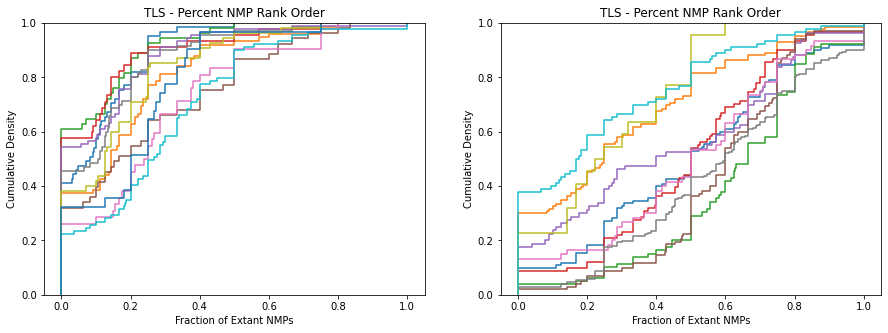

In [78]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax1 = ax[0]
ax1.set_title('TLS - Percent NMP Rank Order')
ax1.set_ylabel('Cumulative Density')
ax1.set_xlabel('Fraction of Extant NMPs')
for barcode in np.unique(node_info[node_info['TLSCL'] == 'TLS']['Barcode']):
    barcode_percents = []
    for row in node_info[(node_info['Barcode'] == barcode) & (node_info['Clone'] != 'Root')].iterrows():
            barcode_percents.append(row[1]['Percent NMP'])

    x = range(len(barcode_percents))
    sns.ecdfplot(barcode_percents, label = barcode, ax = ax1)

ax2 = ax[1]
ax2.set_title('TLS - Percent NMP Rank Order')
ax2.set_ylabel('Cumulative Density')
ax2.set_xlabel('Fraction of Extant NMPs')
for barcode in np.unique(node_info[node_info['TLSCL'] == 'TLSCL']['Barcode']):
    barcode_percents = []
    for row in node_info[(node_info['Barcode'] == barcode) & (node_info['Clone'] != 'Root')].iterrows():
            barcode_percents.append(row[1]['Percent NMP'])

    x = range(len(barcode_percents))

    sns.ecdfplot(barcode_percents, label = barcode, ax = ax2)

plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLS_TLSCL_Percent_NMP_cdf.pdf', dpi = 300)
plt.show()
plt.close()

In [79]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax1 = ax[0]
x = range(len(TLS_NMP_percents))
ax1.scatter(x = x, y = sorted(TLS_NMP_percents, reverse = True))
ax1.set_title('TLS - Percent NMP Rank Order')
ax1.set_xlabel('Node Rank Order')
ax1.set_ylabel('Fraction of Extant NMPs')

ax2 = ax[1]
x = range(len(TLSCL_NMP_percents))
ax2.scatter(x = x, y = sorted(TLSCL_NMP_percents, reverse = True))
ax2.set_title('TLS - Percent NMP Rank Order')
ax2.set_xlabel('Node Rank Order')
ax2.set_ylabel('Fraction of Extant NMPs')

plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLS_TLSCL_Percent_NMP_Rank_Order.pdf', dpi = 300)
#plt.show()
plt.close()

In [80]:
from scipy.interpolate import make_interp_spline

x = np.arange(len(TLSCL_NMP_percents)) / len(TLSCL_NMP_percents)
y = sorted(TLSCL_NMP_percents, reverse = True)

xnew = np.linspace(x.min(), x.max(), 300)
gfg = make_interp_spline(x, y, k=3)
ynew = gfg(xnew)

plt.plot(xnew, ynew, color = 'darkred')


x2 = np.arange(len(TLS_NMP_percents)) / len(TLS_NMP_percents)
y2 = sorted(TLS_NMP_percents, reverse = True)

xnew2 = np.linspace(x2.min(), x2.max(), 300)
gfg2 = make_interp_spline(x2, y2, k=11)
ynew2 = gfg2(xnew2)

plt.plot(xnew2, ynew2, color = 'red')
plt.legend(labels=['TLSCL', 'TLS'])
plt.xlabel('Node Rank Order')
plt.ylabel('Fraction of Extant NMPs')
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLS_TLSCL_Percent_NMP_Rank_Order_Combined.pdf', dpi = 300)
#plt.show()
plt.close()  

In [81]:
TLS_bipotent_fracs = []
for barcode in np.unique(node_info[node_info['TLSCL'] == 'TLS']['Barcode']):
    TLS_bipotent_fracs.append(len(node_info[(node_info['Barcode'] == barcode) & (node_info['Progenitor Type'].isin(['Bipotent', 'Transient NMP']))]) / 
                              len(node_info[node_info['Barcode'] == barcode]))

In [82]:
TLSCL_bipotent_fracs = []
for barcode in np.unique(node_info[node_info['TLSCL'] == 'TLSCL']['Barcode']):
    TLSCL_bipotent_fracs.append(len(node_info[(node_info['Barcode'] == barcode) & (node_info['Progenitor Type'].isin(['Bipotent', 'Transient NMP']))]) / 
                              len(node_info[node_info['Barcode'] == barcode]))

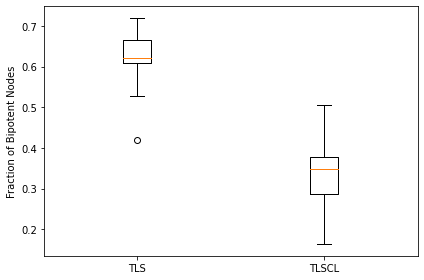

In [83]:
plt.boxplot([TLS_bipotent_fracs, TLSCL_bipotent_fracs],
            labels = ['TLS', 'TLSCL'])
plt.ylabel('Fraction of Bipotent Nodes')
plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLS_TLSCL_Fraction_Bipotent_Nodes.pdf', dpi = 300)
plt.show()

In [84]:
# Calculate and print out counts of each progenitor type for TLS
test = node_info[(node_info['TLSCL'] == 'TLS')]

print('TLS Bipotent Count: ' + str(len(test[test['Progenitor Type'].isin(['Bipotent', 'Transient NMP'])])))
print('TLS Bipotent Fraction: ' + str(len(test[test['Progenitor Type'].isin(['Bipotent', 'Transient NMP'])]) / len(test)))

print('TLS Proliferating Count: ' + str(len(test[test['Progenitor Type'].isin(['Proliferating'])])))
print('TLS Proliferating Fraction: ' + str(len(test[test['Progenitor Type'].isin(['Proliferating'])]) / len(test)))

print('TLS Neural Committed Count: ' + str(len(test[test['Progenitor Type'].isin(['Neural Committed'])])))
print('TLS Neural Committed Fraction: ' + str(len(test[test['Progenitor Type'].isin(['Neural Committed'])]) / len(test)))

print('TLS Somitic Committed Count: ' + str(len(test[test['Progenitor Type'].isin(['Somitic Committed'])])))
print('TLS Somitic Committed Fraction: ' + str(len(test[test['Progenitor Type'].isin(['Somitic Committed'])]) / len(test)))

print('TLS Differentiating Count: ' + str(len(test[test['Progenitor Pool'].isin(['Differentiating'])])))
print('TLS Differentiating Fraction: ' + str(len(test[test['Progenitor Pool'].isin(['Differentiating'])]) / len(test)))

print('TLS Exhausted Count: ' + str(len(test[test['Progenitor Pool'].isin(['Exhausted'])])))
print('TLS Exhausted Fraction: ' + str(len(test[test['Progenitor Pool'].isin(['Exhausted'])]) / len(test)))

differentiating_test = test[test['Progenitor Pool'] == 'Differentiating']
exhausted_test = test[test['Progenitor Pool'] == 'Exhausted']

print('TLS % NMP in Exhausted: ' + str(exhausted_test['Percent NMP'].mean()))
print('TLS % Neural in Exhausted: ' + str(exhausted_test['Percent Neural'].mean()))
print('TLS % Somitic in Exhausted: ' + str(exhausted_test['Percent Somitic'].mean()))
print('TLS % NMP in Differentiating: ' + str(differentiating_test['Percent NMP'].mean()))
print('TLS % Neural in Differentiating: ' + str(differentiating_test['Percent Neural'].mean()))
print('TLS % Somitic in Differentiating: ' + str(differentiating_test['Percent Somitic'].mean()))
print('TLS - % Neural mean / (% Neural + % Somitic): ' + str(differentiating_test['Percent Neural'].mean() / (differentiating_test['Percent Neural'].mean() + differentiating_test['Percent Somitic'].mean())))
print('TLS - % Somitic mean / (% Neural + % Somitic): ' + str(differentiating_test['Percent Somitic'].mean() /(differentiating_test['Percent Neural'].mean() + differentiating_test['Percent Somitic'].mean())))

TLS Bipotent Count: 414
TLS Bipotent Fraction: 0.6225563909774436
TLS Proliferating Count: 3
TLS Proliferating Fraction: 0.004511278195488722
TLS Neural Committed Count: 164
TLS Neural Committed Fraction: 0.24661654135338346
TLS Somitic Committed Count: 84
TLS Somitic Committed Fraction: 0.12631578947368421
TLS Differentiating Count: 390
TLS Differentiating Fraction: 0.5864661654135338
TLS Exhausted Count: 272
TLS Exhausted Fraction: 0.40902255639097745
TLS % NMP in Exhausted: 0.0
TLS % Neural in Exhausted: 0.6611238831959386
TLS % Somitic in Exhausted: 0.3388761168040614
TLS % NMP in Differentiating: 0.2735954268248025
TLS % Neural in Differentiating: 0.4379190725724731
TLS % Somitic in Differentiating: 0.2884855006027243
TLS - % Neural mean / (% Neural + % Somitic): 0.6028583639806655
TLS - % Somitic mean / (% Neural + % Somitic): 0.3971416360193346


In [88]:
# Calculate and print out counts of each progenitor type for TLS
test = node_info[(node_info['TLSCL'] == 'TLSCL')]

print('TLSCL Bipotent Count: ' + str(len(test[test['Progenitor Type'].isin(['Bipotent', 'Transient NMP'])])))
print('TLSCL Bipotent Fraction: ' + str(len(test[test['Progenitor Type'].isin(['Bipotent', 'Transient NMP'])]) / len(test)))

print('TLSCL Proliferating Count: ' + str(len(test[test['Progenitor Type'].isin(['Proliferating'])])))
print('TLSCL Proliferating Fraction: ' + str(len(test[test['Progenitor Type'].isin(['Proliferating'])]) / len(test)))

print('TLSCL Neural Committed Count: ' + str(len(test[test['Progenitor Type'].isin(['Neural Committed'])])))
print('TLSCL Neural Committed Fraction: ' + str(len(test[test['Progenitor Type'].isin(['Neural Committed'])]) / len(test)))

print('TLSCL Somitic Committed Count: ' + str(len(test[test['Progenitor Type'].isin(['Somitic Committed'])])))
print('TLSCL Somitic Committed Fraction: ' + str(len(test[test['Progenitor Type'].isin(['Somitic Committed'])]) / len(test)))

print('TLSCL Differentiating Count: ' + str(len(test[test['Progenitor Pool'].isin(['Differentiating'])])))
print('TLSCL Differentiating Fraction: ' + str(len(test[test['Progenitor Pool'].isin(['Differentiating'])]) / len(test)))

print('TLSCL Exhausted Count: ' + str(len(test[test['Progenitor Pool'].isin(['Exhausted'])])))
print('TLSCL Exhausted Fraction: ' + str(len(test[test['Progenitor Pool'].isin(['Exhausted'])]) / len(test)))

differentiating_test = test[test['Progenitor Pool'] == 'Differentiating']
exhausted_test = test[test['Progenitor Pool'] == 'Exhausted']

print('TLSCL % NMP in Exhausted: ' + str(exhausted_test['Percent NMP'].mean()))
print('TLSCL % Neural in Exhausted: ' + str(exhausted_test['Percent Neural'].mean()))
print('TLSCL % Somitic in Exhausted: ' + str(exhausted_test['Percent Somitic'].mean()))
print('TLSCL % NMP in Differentiating: ' + str(differentiating_test['Percent NMP'].mean()))
print('TLSCL % Neural in Differentiating: ' + str(differentiating_test['Percent Neural'].mean()))
print('TLSCL % Somitic in Differentiating: ' + str(differentiating_test['Percent Somitic'].mean()))
print('TLSCL - % Neural mean / (% Neural + % Somitic): ' + str(differentiating_test['Percent Neural'].mean() / (differentiating_test['Percent Neural'].mean() + differentiating_test['Percent Somitic'].mean())))
print('TLSCL - % Somitic mean / (% Neural + % Somitic): ' + str(differentiating_test['Percent Somitic'].mean() /(differentiating_test['Percent Neural'].mean() + differentiating_test['Percent Somitic'].mean())))

TLSCL Bipotent Count: 304
TLSCL Bipotent Fraction: 0.32653061224489793
TLSCL Proliferating Count: 48
TLSCL Proliferating Fraction: 0.05155746509129968
TLSCL Neural Committed Count: 150
TLSCL Neural Committed Fraction: 0.1611170784103115
TLSCL Somitic Committed Count: 429
TLSCL Somitic Committed Fraction: 0.4607948442534909
TLSCL Differentiating Count: 755
TLSCL Differentiating Fraction: 0.8109559613319012
TLSCL Exhausted Count: 128
TLSCL Exhausted Fraction: 0.13748657357679914
TLSCL % NMP in Exhausted: 0.0
TLSCL % Neural in Exhausted: 0.09973958333333333
TLSCL % Somitic in Exhausted: 0.9002604166666667
TLSCL % NMP in Differentiating: 0.5126702513739471
TLSCL % Neural in Differentiating: 0.15636342599226358
TLSCL % Somitic in Differentiating: 0.3309663226337894
TLSCL - % Neural mean / (% Neural + % Somitic): 0.32085754344590056
TLSCL - % Somitic mean / (% Neural + % Somitic): 0.6791424565540995


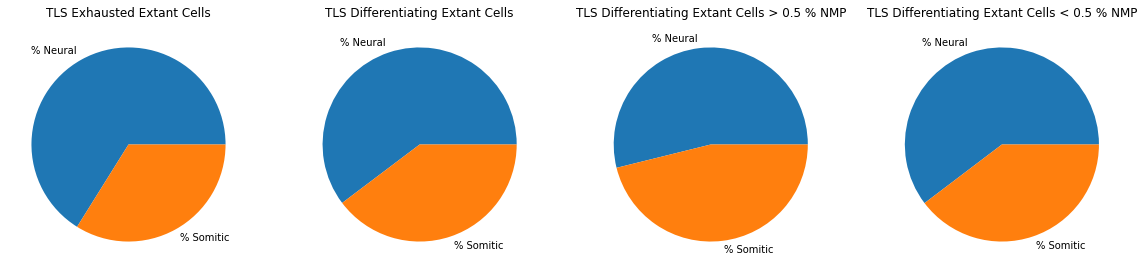

In [89]:
test = node_info[(node_info['TLSCL'] == 'TLS')]
differentiating_test = test[test['Progenitor Pool'] == 'Differentiating']
exhausted_test = test[test['Progenitor Pool'] == 'Exhausted']

fig, ax = plt.subplots(1, 4, figsize = (20, 5))

ax1 = ax[0]
ratios = [exhausted_test['Percent Neural'].mean(),
         exhausted_test['Percent Somitic'].mean()]
ax1.pie(ratios, labels = ['% Neural', '% Somitic'])
ax1.set_title('TLS Exhausted Extant Cells')

ax2 = ax[1]
ratios = [differentiating_test['Percent Neural'].mean() / (differentiating_test['Percent Neural'].mean() + differentiating_test['Percent Somitic'].mean()),
         differentiating_test['Percent Somitic'].mean() / (differentiating_test['Percent Neural'].mean() + differentiating_test['Percent Somitic'].mean())]
ax2.pie(ratios, labels = ['% Neural', '% Somitic'])
ax2.set_title('TLS Differentiating Extant Cells')

ax3 = ax[2]
ratios = [differentiating_test[differentiating_test['Percent NMP'] > 0.5]['Percent Neural'].mean() / (differentiating_test[differentiating_test['Percent NMP'] > 0.5]['Percent Neural'].mean() + differentiating_test[differentiating_test['Percent NMP'] > 0.5]['Percent Somitic'].mean()),
         differentiating_test[differentiating_test['Percent NMP'] > 0.5]['Percent Somitic'].mean() / (differentiating_test[differentiating_test['Percent NMP'] > 0.5]['Percent Neural'].mean() + differentiating_test[differentiating_test['Percent NMP'] > 0.5]['Percent Somitic'].mean())]
ax3.pie(ratios, labels = ['% Neural', '% Somitic'])
ax3.set_title('TLS Differentiating Extant Cells > 0.5 % NMP')

ax4 = ax[3]
ratios = [differentiating_test[differentiating_test['Percent NMP'] < 0.5]['Percent Neural'].mean() / (differentiating_test[differentiating_test['Percent NMP'] < 0.5]['Percent Neural'].mean() + differentiating_test[differentiating_test['Percent NMP'] < 0.5]['Percent Somitic'].mean()),
         differentiating_test[differentiating_test['Percent NMP'] < 0.5]['Percent Somitic'].mean() / (differentiating_test[differentiating_test['Percent NMP'] < 0.5]['Percent Neural'].mean() + differentiating_test[differentiating_test['Percent NMP'] < 0.5]['Percent Somitic'].mean())]
ax4.pie(ratios, labels = ['% Neural', '% Somitic'])
ax4.set_title('TLS Differentiating Extant Cells < 0.5 % NMP')

plt.show()
plt.close()

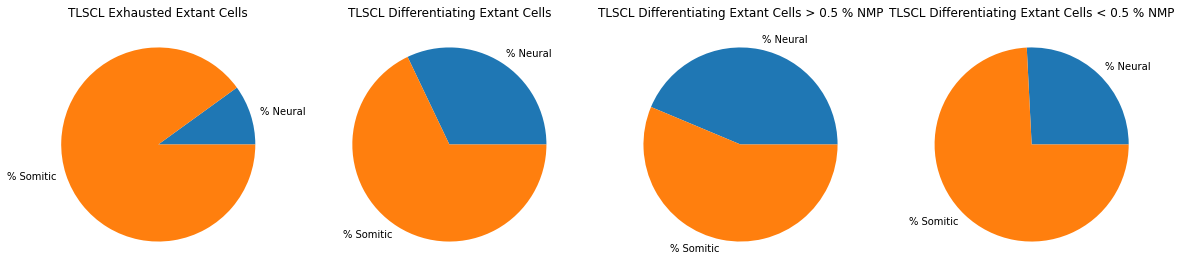

In [90]:
test = node_info[(node_info['TLSCL'] == 'TLSCL')]
differentiating_test = test[test['Progenitor Pool'] == 'Differentiating']
exhausted_test = test[test['Progenitor Pool'] == 'Exhausted']

fig, ax = plt.subplots(1, 4, figsize = (20, 5))

ax1 = ax[0]
ratios = [exhausted_test['Percent Neural'].mean(),
         exhausted_test['Percent Somitic'].mean()]
ax1.pie(ratios, labels = ['% Neural', '% Somitic'])
ax1.set_title('TLSCL Exhausted Extant Cells')

ax2 = ax[1]
ratios = [differentiating_test['Percent Neural'].mean() / (differentiating_test['Percent Neural'].mean() + differentiating_test['Percent Somitic'].mean()),
         differentiating_test['Percent Somitic'].mean() / (differentiating_test['Percent Neural'].mean() + differentiating_test['Percent Somitic'].mean())]
ax2.pie(ratios, labels = ['% Neural', '% Somitic'])
ax2.set_title('TLSCL Differentiating Extant Cells')

ax3 = ax[2]
ratios = [differentiating_test[differentiating_test['Percent NMP'] > 0.5]['Percent Neural'].mean() / (differentiating_test[differentiating_test['Percent NMP'] > 0.5]['Percent Neural'].mean() + differentiating_test[differentiating_test['Percent NMP'] > 0.5]['Percent Somitic'].mean()),
         differentiating_test[differentiating_test['Percent NMP'] > 0.5]['Percent Somitic'].mean() / (differentiating_test[differentiating_test['Percent NMP'] > 0.5]['Percent Neural'].mean() + differentiating_test[differentiating_test['Percent NMP'] > 0.5]['Percent Somitic'].mean())]
ax3.pie(ratios, labels = ['% Neural', '% Somitic'])
ax3.set_title('TLSCL Differentiating Extant Cells > 0.5 % NMP')

ax4 = ax[3]
ratios = [differentiating_test[differentiating_test['Percent NMP'] < 0.5]['Percent Neural'].mean() / (differentiating_test[differentiating_test['Percent NMP'] < 0.5]['Percent Neural'].mean() + differentiating_test[differentiating_test['Percent NMP'] < 0.5]['Percent Somitic'].mean()),
         differentiating_test[differentiating_test['Percent NMP'] < 0.5]['Percent Somitic'].mean() / (differentiating_test[differentiating_test['Percent NMP'] < 0.5]['Percent Neural'].mean() + differentiating_test[differentiating_test['Percent NMP'] < 0.5]['Percent Somitic'].mean())]
ax4.pie(ratios, labels = ['% Neural', '% Somitic'])
ax4.set_title('TLSCL Differentiating Extant Cells < 0.5 % NMP')

plt.show()
plt.close()

# Violin plots of progenitor type fractions

In [92]:
temp = node_type_frac.copy().T

In [93]:
index_labels = []
for barcode in temp.index.values:
    for progenitor in ['Bipotent', 'Neural Committed', 'Somitic Committed', 'Proliferating']:
        index_labels.append(barcode + '_' + progenitor)

In [94]:
temp2 = pd.DataFrame(index = index_labels, columns = ['Barcode', 'Value', 'Progenitor Type', 'TLSCL'])

In [95]:
for barcode in temp.index.values:
    for progenitor in ['Bipotent', 'Neural Committed', 'Somitic Committed', 'Proliferating']:
        temp2.loc[barcode + '_' + progenitor]['Value'] = temp.loc[barcode][progenitor]
        
        temp2.loc[barcode + '_' + progenitor]['Barcode'] = barcode
        temp2.loc[barcode + '_' + progenitor]['Progenitor Type'] = progenitor
        
temp2['TLSCL'] = temp2['Barcode'].map(addTLSCL)

In [96]:
temp['TLSCL'] = temp.index.map(addTLSCL)

In [97]:
temp2['Value'] = temp2['Value'].astype('float')

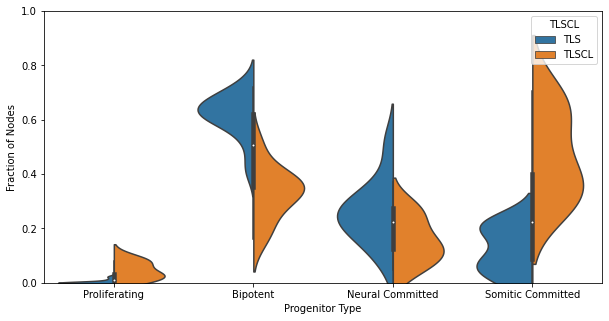

In [98]:
fig, ax = plt.subplots(figsize = (10, 5))

sns.violinplot(data=temp2, x = 'Progenitor Type', y = 'Value', scale = 'count', split = True, hue = 'TLSCL',
              order = ['Proliferating', 'Bipotent', 'Neural Committed', 'Somitic Committed'])
plt.ylabel('Fraction of Nodes')
plt.ylim(0, 1)
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/Progenitor_Type_Fractions.pdf', dpi = 300)
plt.show()
plt.close()

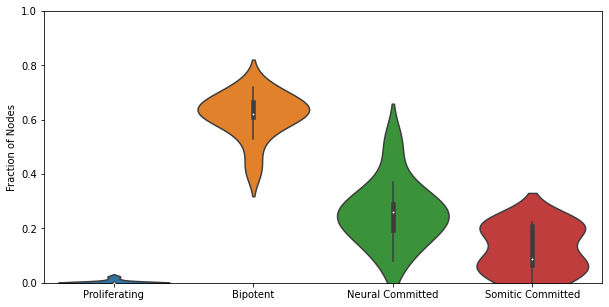

In [99]:
fig, ax = plt.subplots(figsize = (10, 5))

sns.violinplot(data=temp[temp['TLSCL'] == 'TLS'], scale = 'count',
              order = ['Proliferating', 'Bipotent', 'Neural Committed', 'Somitic Committed'])
plt.ylabel('Fraction of Nodes')
plt.ylim(0, 1)
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLS_Progenitor_Type_Fractions.pdf', dpi = 300)
plt.show()
plt.close()

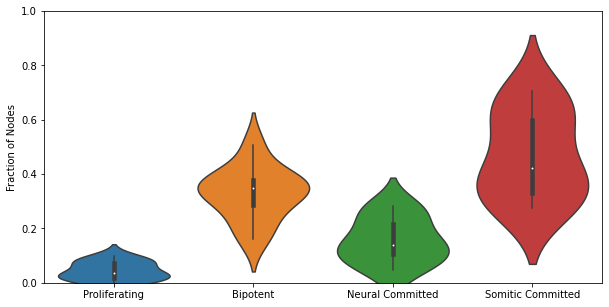

In [100]:
fig, ax = plt.subplots(figsize = (10, 5))

sns.violinplot(data=temp[temp['TLSCL'] == 'TLSCL'], scale = 'count',
              order = ['Proliferating', 'Bipotent', 'Neural Committed', 'Somitic Committed'])
plt.ylabel('Fraction of Nodes')
plt.ylim(0, 1)
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLSCL_Progenitor_Type_Fractions.pdf', dpi = 300)
plt.show()
plt.close()

# Violin plot of node pool fractions

In [102]:
pool_temp = node_pool_frac.copy().T

In [103]:
pool_index_labels = []
for barcode in pool_temp.index.values:
    for progenitor in ['Proliferating', 'Differentiating', 'Exhausted']:
        pool_index_labels.append(barcode + '_' + progenitor)

In [104]:
pool_temp2 = pd.DataFrame(index = pool_index_labels, columns = ['Barcode', 'Value', 'Progenitor Type', 'TLSCL'])

In [105]:
for barcode in temp.index.values:
    for progenitor in ['Proliferating', 'Differentiating', 'Exhausted']:
        pool_temp2.loc[barcode + '_' + progenitor]['Value'] = pool_temp.loc[barcode][progenitor]
        
        pool_temp2.loc[barcode + '_' + progenitor]['Barcode'] = barcode
        pool_temp2.loc[barcode + '_' + progenitor]['Progenitor Type'] = progenitor
        
pool_temp2['TLSCL'] = pool_temp2['Barcode'].map(addTLSCL)

In [106]:
pool_temp2['Value'] = pool_temp2['Value'].astype('float')

In [107]:
pool_temp['TLSCL'] = pool_temp.index.map(addTLSCL)

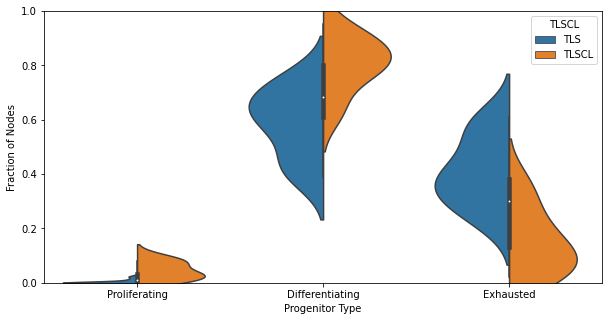

In [108]:
fig, ax = plt.subplots(figsize = (10, 5))

sns.violinplot(data=pool_temp2, x = 'Progenitor Type', y = 'Value', scale = 'count', split = True, hue = 'TLSCL',
              order = ['Proliferating', 'Differentiating', 'Exhausted'])
plt.ylabel('Fraction of Nodes')
plt.ylim(0, 1)
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/Differentiation_Type_Fractions.pdf', dpi = 300)
plt.show()
plt.close()

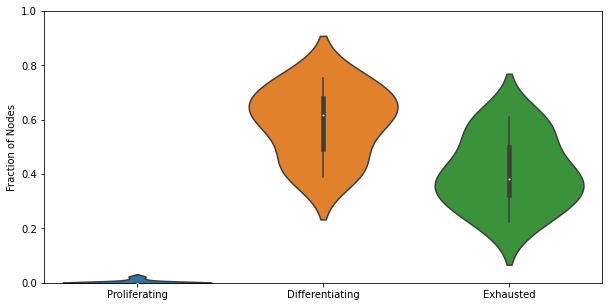

In [109]:
fig, ax = plt.subplots(figsize = (10, 5))

sns.violinplot(data=pool_temp[pool_temp['TLSCL'] == 'TLS'], scale = 'count',
              order = ['Proliferating', 'Differentiating', 'Exhausted'])
plt.ylabel('Fraction of Nodes')
plt.ylim(0, 1)
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLS_Differentiation_Type_Fractions.pdf', dpi = 300)
plt.show()
plt.close()

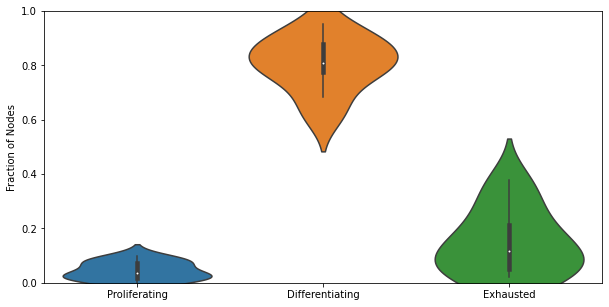

In [110]:
fig, ax = plt.subplots(figsize = (10, 5))

sns.violinplot(data=pool_temp[pool_temp['TLSCL'] == 'TLSCL'], scale = 'count',
              order = ['Proliferating', 'Differentiating', 'Exhausted'])
plt.ylabel('Fraction of Nodes')
plt.ylim(0, 1)
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/progenitor_analysis/TLSCL_Differentiation_Type_Fractions.pdf', dpi = 300)
plt.show()
plt.close()